I have decided to see if there are any outliers in the dataset according to [Chauvenet's criterion](https://en.wikipedia.org/wiki/Chauvenet%27s_criterion)

An observation $P_i$ is an outlier if the following equation is true:
$$erfc\Bigg(\frac{|P_i - \bar{P}|}{S_p}\Bigg) < \frac{1}{2n}$$

$$erfc(x) = \frac{2}{\sqrt{\pi}} \int_x^\infty \mathrm{e}^{-t}\;\mathrm{d}t$$

In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.special import erfc
import scipy
warnings.simplefilter('ignore')
plt.style.use('seaborn')
for package in [pd, np, scipy, sns]:
    print(package.__name__, 'version:', package.__version__)
print(os.listdir("../input"))

pandas version: 0.23.4
numpy version: 1.16.2
scipy version: 1.1.0
seaborn version: 0.9.0
['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
def load_dataframe(dataset):
    return pd.read_csv(dataset)

with multiprocessing.Pool() as pool:
    train, test = pool.map(load_dataframe, ['../input/train.csv', '../input/test.csv'])

In [3]:
def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = erfc(d)                # Area normal dist.    
    return prob < criterion       # Use boolean array outside this function

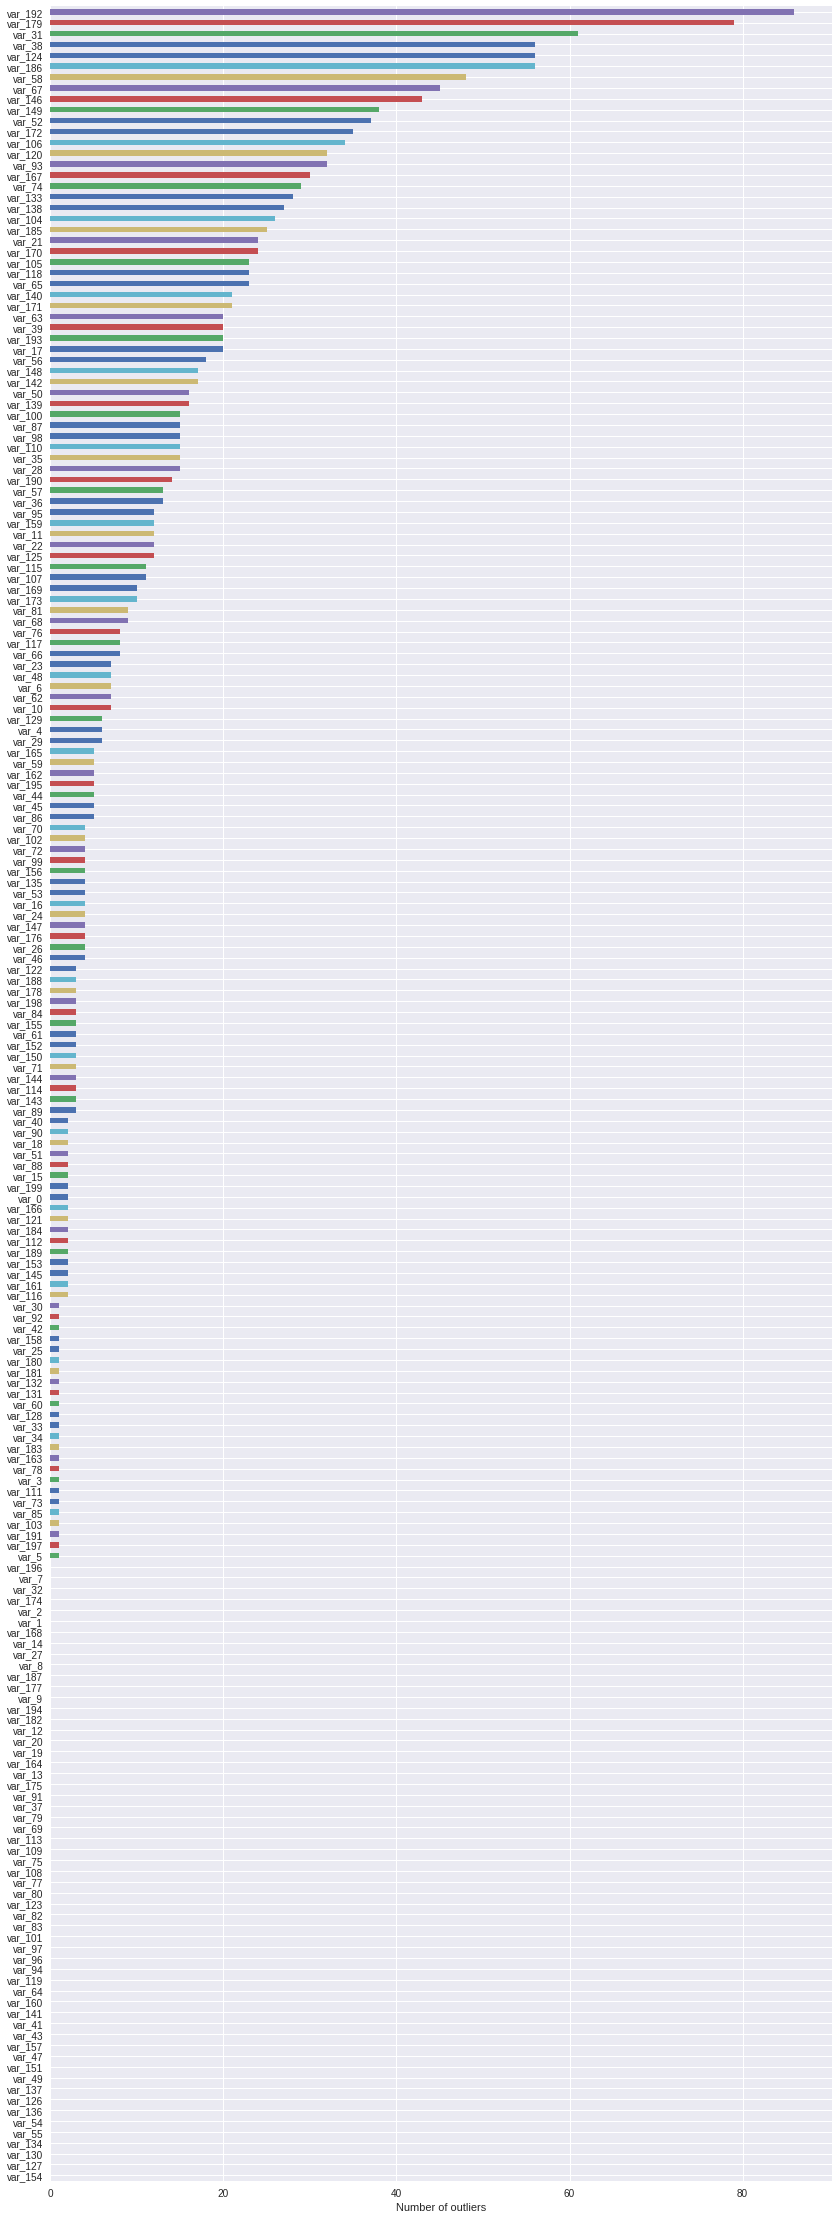

In [4]:
train_outliers = dict()
for col in [col for col in train.columns if 'var_' in col]:
    train_outliers[col] = train[chauvenet(train[col].values)].shape[0]
train_outliers = pd.Series(train_outliers)

train_outliers.sort_values().plot(figsize=(14, 40), kind='barh').set_xlabel('Number of outliers');

In [5]:
print('Total number of outliers in training set: {} ({:.2f}%)'.format(sum(train_outliers.values), (sum(train_outliers.values) / train.shape[0]) * 100))

Total number of outliers in training set: 1740 (0.87%)


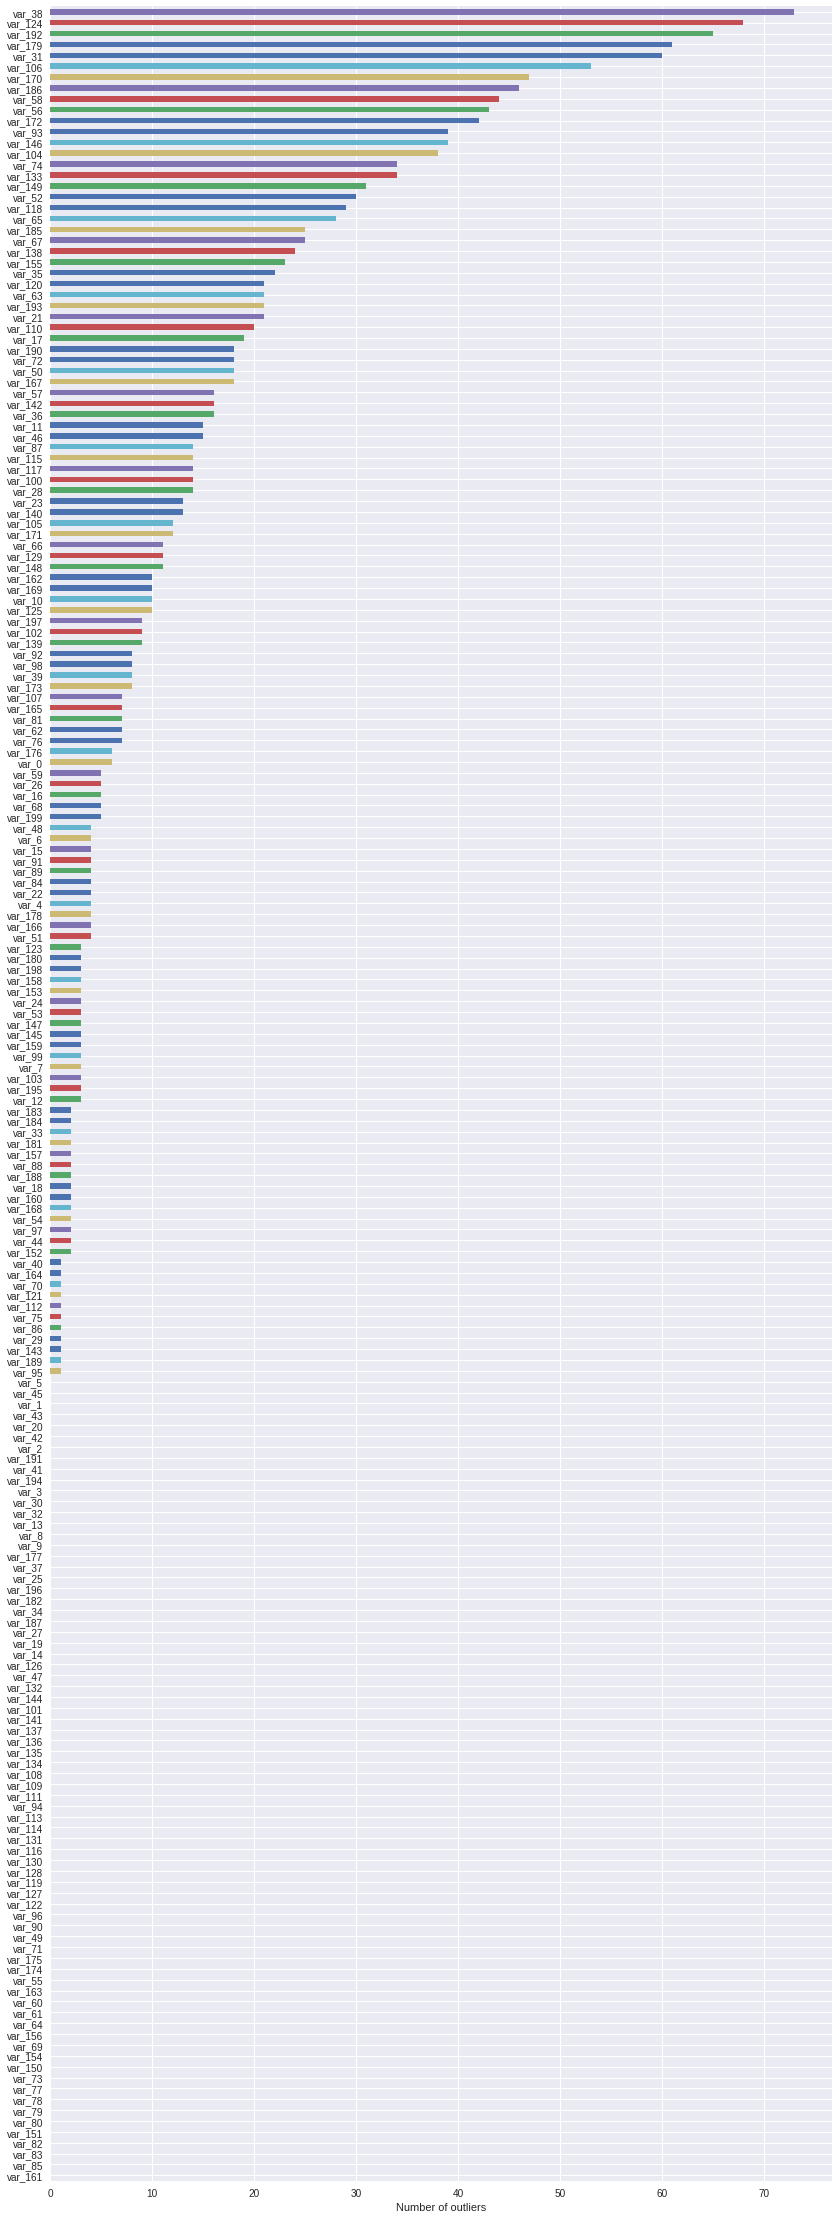

In [6]:
test_outliers = dict()
for col in [col for col in test.columns if 'var_' in col]:
    test_outliers[col] = test[chauvenet(test[col].values)].shape[0]
test_outliers = pd.Series(test_outliers)

test_outliers.sort_values().plot(figsize=(14, 40), kind='barh').set_xlabel('Number of outliers');

In [7]:
print('Total number of outliers in testing set: {} ({:.2f}%)'.format(sum(test_outliers.values), (sum(test_outliers.values) / test.shape[0]) * 100))

Total number of outliers in testing set: 1748 (0.87%)


Plots with a distribution for 5 top features before removing an outliers and after removing them.

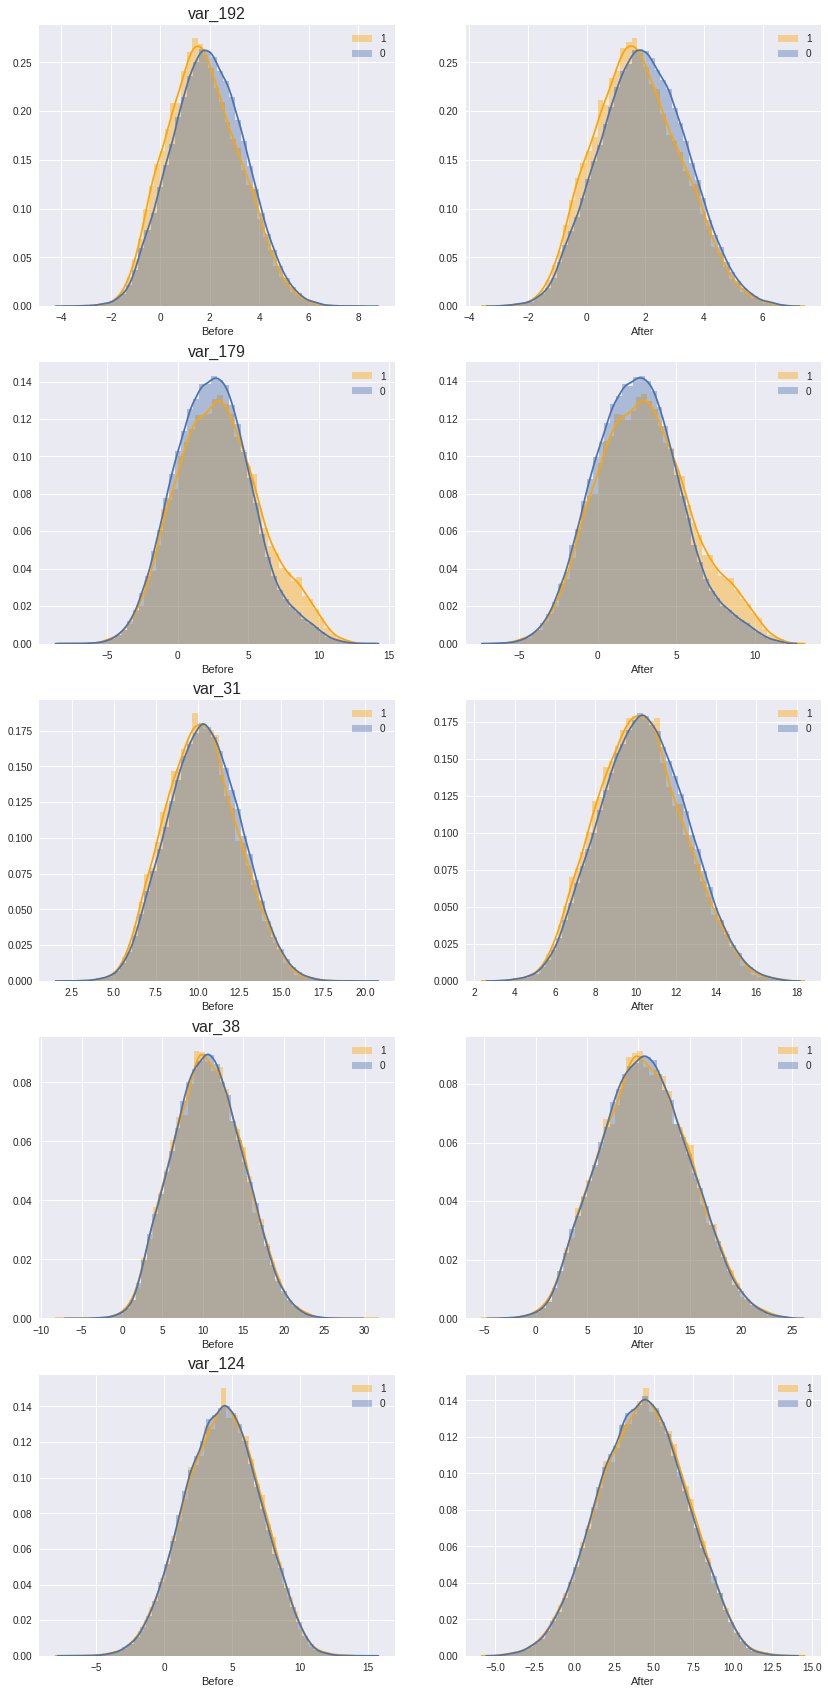

In [8]:
rows = train_outliers.sort_values(ascending=False).head().index.shape[0]
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(14, rows * 6))
for i, col in enumerate(train_outliers.sort_values(ascending=False).head().index):
    sns.distplot(train[(train['target'] == 1)][col].values, ax=axes[i, 0], axlabel='Before', color='orange', label='1');
    sns.distplot(train[(train['target'] == 0)][col].values, ax=axes[i, 0], label='0');
    sns.distplot(train[(~chauvenet(train[col].values)) & (train['target'] == 1)][col].values, ax=axes[i, 1], axlabel='After', color='orange', label='1');
    sns.distplot(train[(~chauvenet(train[col].values)) & (train['target'] == 0)][col].values, ax=axes[i, 1], label='0');
    axes[i, 0].set_title(col, fontsize=16)
    axes[i, 0].legend()
    axes[i, 1].legend()